<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/05_measuring_problem_radius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Hardware specs**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


## **🚀 Setting up the environment**

In [92]:
import os, sys
import os.path as osp
from google.colab import drive, files
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [93]:
import time
import concurrent.futures
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from collections import Counter
from torch_geometric.utils import to_dense_adj
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style('whitegrid')

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

## **🧰 Utility functions**

In [94]:
def hop_neighbors(k:int, dense_adj: torch.Tensor):
    cum_neighbors = pow_A = dense_adj

    yield dense_adj, dense_adj

    for _ in range(k-1):
        # pow_A = torch.sparse.mm(edge_index, pow_A)
        pow_A = torch.spmm(dense_adj, pow_A)
        # neighbors = ((pow_A > 0) - cum_neighbors) > 0

        neighbors = torch.where(
            torch.where(pow_A > 0, 1, 0) - cum_neighbors > 0,
            1, 0)
        
        cum_neighbors += neighbors
        
        yield neighbors, cum_neighbors

In [95]:
def scale(X:torch.Tensor):
    """Returns the scaled features of the graph

    Args:
        - X [num_nodes, num_features]
    """
   
    m = X.mean(0)
    s = X.std(0)
    ones = torch.ones(s.shape).to(device)
    s = torch.where(s == 0, ones, s)
    return (X - m)/ s

In [96]:
def centroids(X:torch.Tensor, y:torch.Tensor):
    """Returns the label representation by averaging its nodes' features

    Args:
        - X [num_nodes, num_features]: node features
        - y [num_nodes]: labels
    """
    num_classes = y.max().item() + 1
    
    # group nodes by label
    obs = {}
    for i in range(X.size(0)):
        if obs.get(y[i].item()):
            obs[y[i].item()] += [X[i]]
        else:
            obs[y[i].item()] = [X[i]]

    return torch.stack([sum(obs[c]) / len(obs[c]) for c in range(num_classes)], 0)

In [97]:
def homophily_index(y:torch.Tensor, neb:torch.tensor, mask=None, optim='memory'):
    """Computes the homophily index for a given depth

    Args:
        - y [num_nodes]: labels of all nodes
        - neb [num_nodes, num_nodes]: neighbors to consider (can be the adjacency matrix or k-hop neighborhood)
        - mask [num_nodes]: "train", "test" or "val" to consider only these specific neighbors
    """
    num_nodes = y.size(0)

    if mask == None:
        mask = torch.ones(num_nodes).to(device)

    if(optim == 'memory'):
        # memory optimized
        return torch.stack([(y[neb[i] * mask == 1] == y[i]).float().mean().to(device) if (neb[i] * mask == 1).sum() > 0 else torch.tensor(0.).to(device) for i in range(num_nodes)], 0)

    if(optim == 'gpu'):
        # gpu optimized
        masked_neb = neb * mask.to(device)
        yy = y.unsqueeze(1).expand(-1, num_nodes).to(device)

        return (((masked_neb.long() * yy.t()) == yy ) * (masked_neb == 1)).sum(1) / ((masked_neb == 1).sum(1) + 1e-8)

In [130]:
def corrcoef(x:torch.Tensor, y:torch.Tensor, x_mean:torch.Tensor, y_mean:torch.Tensor):
    if x == [] or x.size(0) == 0: return torch.tensor(0.)

    c = torch.matmul(x.sub(x.mean(1, keepdim=True)), y.sub(y.mean(0, keepdim=True)).t()) / x.size(1)
    c = c / (x.std(1) * y.std())
    return c.clamp(-1.0, 1.0)

In [ ]:
def graph_correlation(neb:torch.Tensor, x:torch.Tensor, y:torch.Tensor):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node

    :rtype: list [num_nodes]: correlation (scalar) for every node
    """
    num_nodes = x.size(0)

    return torch.stack([corrcoef(x=x[neb[i] == 1], y=y[i]).abs().mean().to(device) for i in range(num_nodes)], 0)

In [134]:
def graph_correlation(neb:torch.Tensor, x:torch.Tensor, y:torch.Tensor):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node
        :rtype: list [num_nodes]: correlation (scalar) for every node
    """

    num_nodes = x.size(0)
    y_scaled = y.sub(y.mean(0))
 
    def corr(x, y, i):
        if x.size(0) == 0: return torch.tensor(0.)
        cov = torch.einsum('ij, j -> i', x, y)
        norm = torch.matmul(x, x.t()).diag().sqrt() * torch.matmul(y, y.t()).sqrt()
        return cov / norm

    return torch.stack([corr(x=x[neb[i] == 1], y=y_scaled[i], i=i).abs().mean().to(device) for i in range(num_nodes)], 0)

## **🧪 Test with different datasets**

In [132]:
def confidence(values: torch.Tensor):
    """Returns the 95% confidence interval of the array of values
    """
    q = 1.96
    m = values.mean()
    s = values.std()
    
    return m - q * s/np.sqrt(len(values)), m + q * s/np.sqrt(len(values))


def graph_summary(dataset, K=20):
    graph = dataset[0].to(device)
    dense_adj = to_dense_adj(graph.edge_index).squeeze(0).to(device)

    x = scale(graph.x)
    scaled_centroids = centroids(x, graph.y)
    y = torch.stack([scaled_centroids[graph.y[i]] for i in range(graph.num_nodes)]).to(device)

    data = pd.DataFrame({'k': [], 'homophily_neighbors':[],
                         'homophily_neighborhood':[],
                         'correlation_neighbors':[],
                         'correlation_neighborhood':[]})

    idx, k = 0, 0
    for neighbors, cum_neighbors in tqdm(hop_neighbors(K+1, dense_adj), total=K):
        k += 1
        homo_neighborhood = homophily_index(y=graph.y, neb=cum_neighbors)
        homo_neighborhood_conf = confidence(homo_neighborhood)
        
        homo_neighbors = homophily_index(y=graph.y, neb=neighbors)
        homo_neighbors_conf = confidence(homo_neighbors)

        corr_neighbors = graph_correlation(neighbors, x=x, y=y)
        corr_neighbors_conf = confidence(corr_neighbors)

        corr_neighborhood = graph_correlation(cum_neighbors, x=x, y=y)
        corr_neighborhood_conf = confidence(corr_neighborhood)

        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[0].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[0].item(),
                         'correlation_neighbors':corr_neighbors_conf[0].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[0].item()}
        idx += 1
        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[1].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[1].item(),
                         'correlation_neighbors':corr_neighbors_conf[1].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[1].item()}
        idx += 1

    _, ax = plt.subplots(1, 2, figsize=(24,12))
    sns.lineplot(ax=ax[0], x='k', y='value', 
                 hue='variable', 
                 data=pd.melt(data[['k', 'homophily_neighbors', 'homophily_neighborhood']], ['k'])).set(xlabel="depth", ylabel="index", title="Homophily")
    sns.lineplot(ax=ax[1], x='k', y='value', 
                 hue='variable',
                 data=pd.melt(data[['k', 'correlation_neighbors', 'correlation_neighborhood']], ['k'])).set(xlabel="depth", ylabel="correlation", title="Correlation")

    return data

In [100]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset
path = osp.join(os.getcwd(), 'data')

### **📰 Cora (short-range)**

In [101]:
# cora dataset
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

  0%|          | 0/20 [00:00<?, ?it/s]

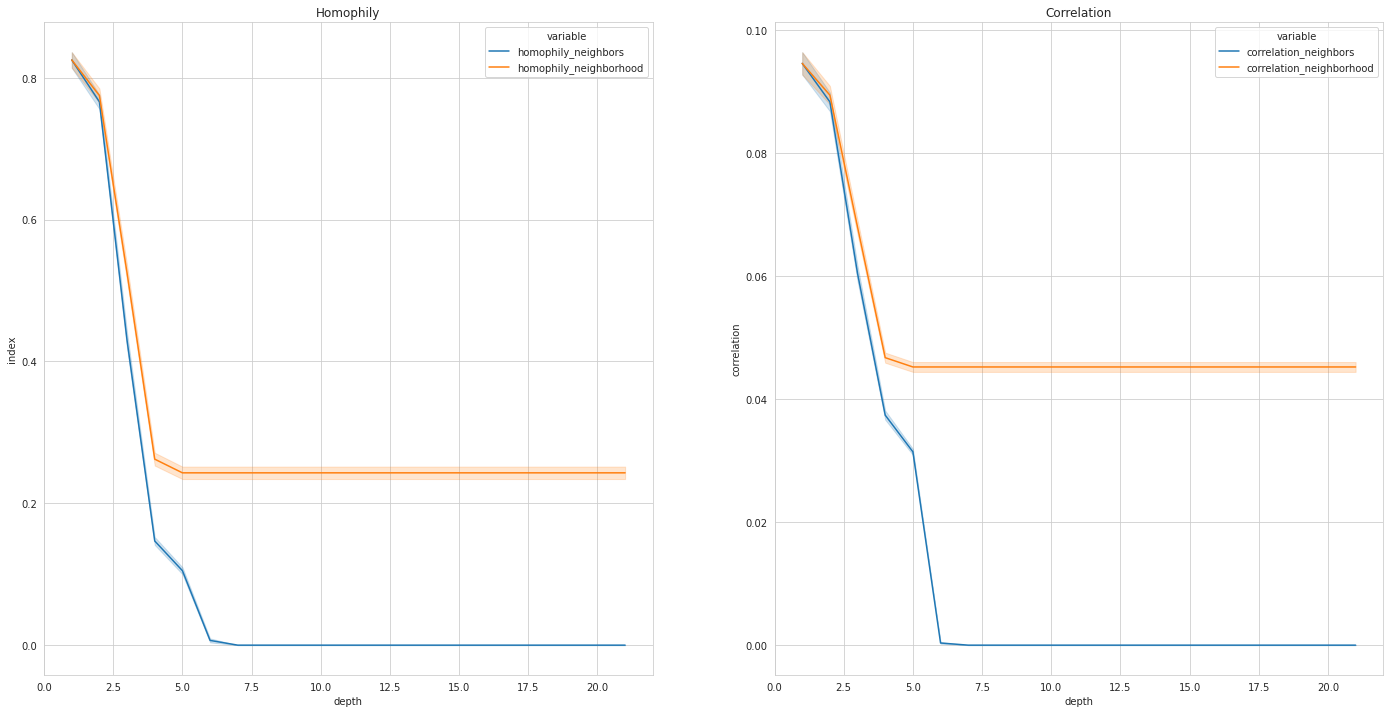

In [135]:
cora_summary = graph_summary(cora_dataset)

  0%|          | 0/20 [00:00<?, ?it/s]

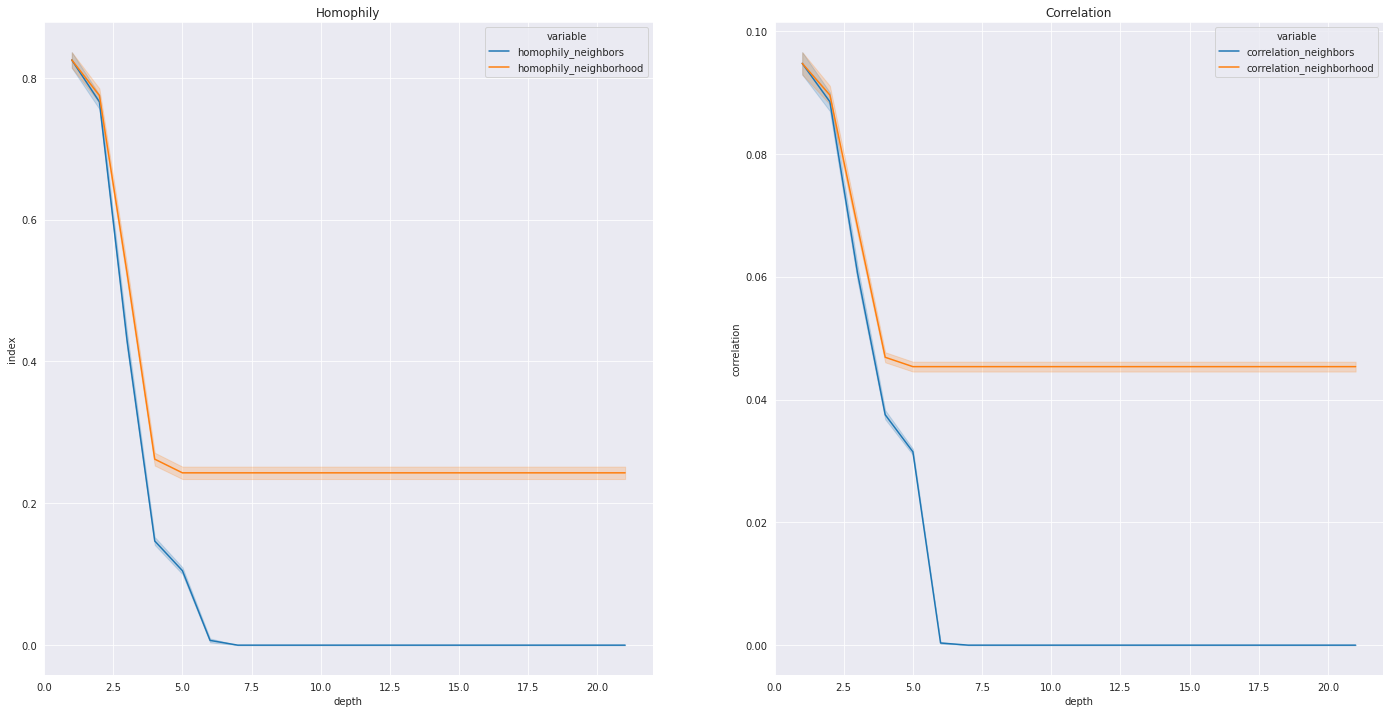

In [ ]:
cora_summary = graph_summary(cora_dataset)

In [ ]:
cora_summary.to_csv("./cora_summary.csv")
files.download('./cora_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **📰 Citeseer**

In [ ]:
citeseer = load_dataset(path, "CiteSeer")

Processing...
Done!


  0%|          | 0/20 [00:00<?, ?it/s]

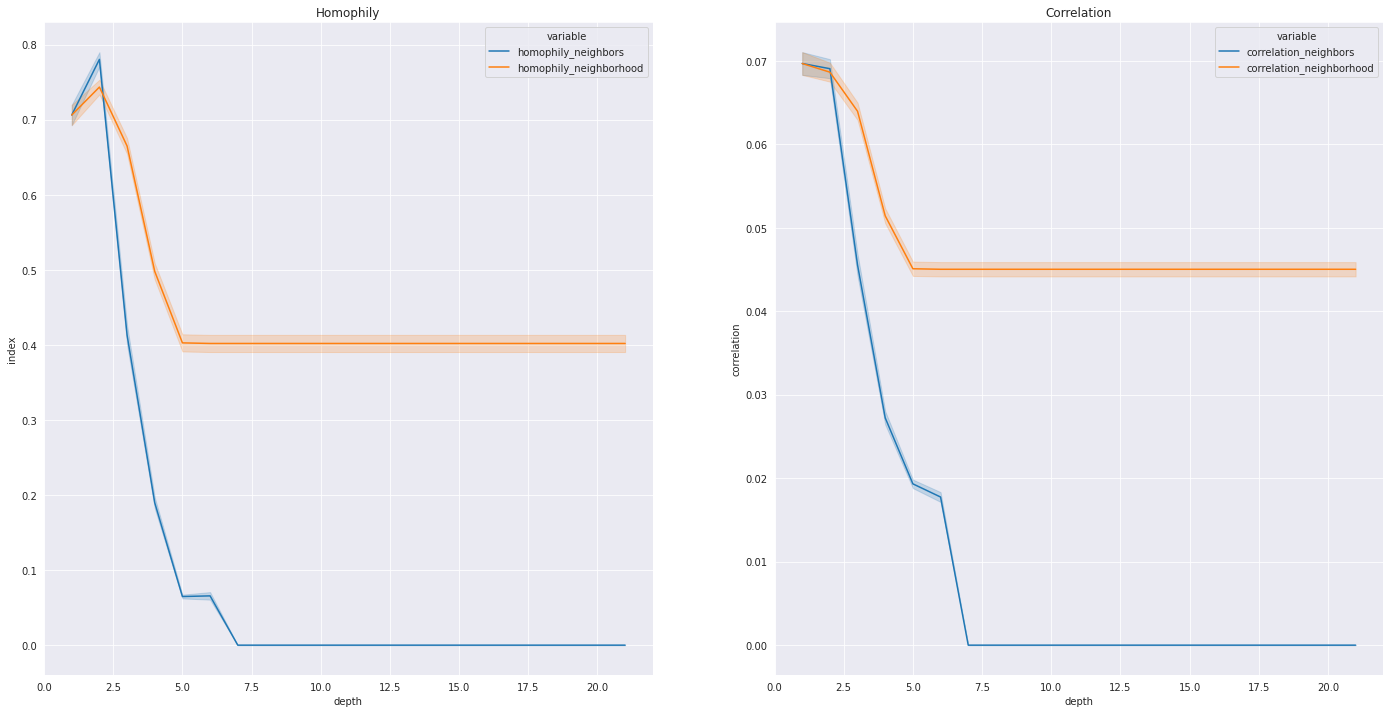

In [ ]:
citeseer_summary = graph_summary(citeseer)

In [ ]:
citeseer_summary.to_csv("./citeseer_summary.csv")
files.download('./citeseer_summary.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **📦 Amazon (short-range)**

In [ ]:
amazon = load_dataset(path, 'Amazon', params=dict(goods="Photo"))

Processing...
Done!


  0%|          | 0/20 [00:00<?, ?it/s]

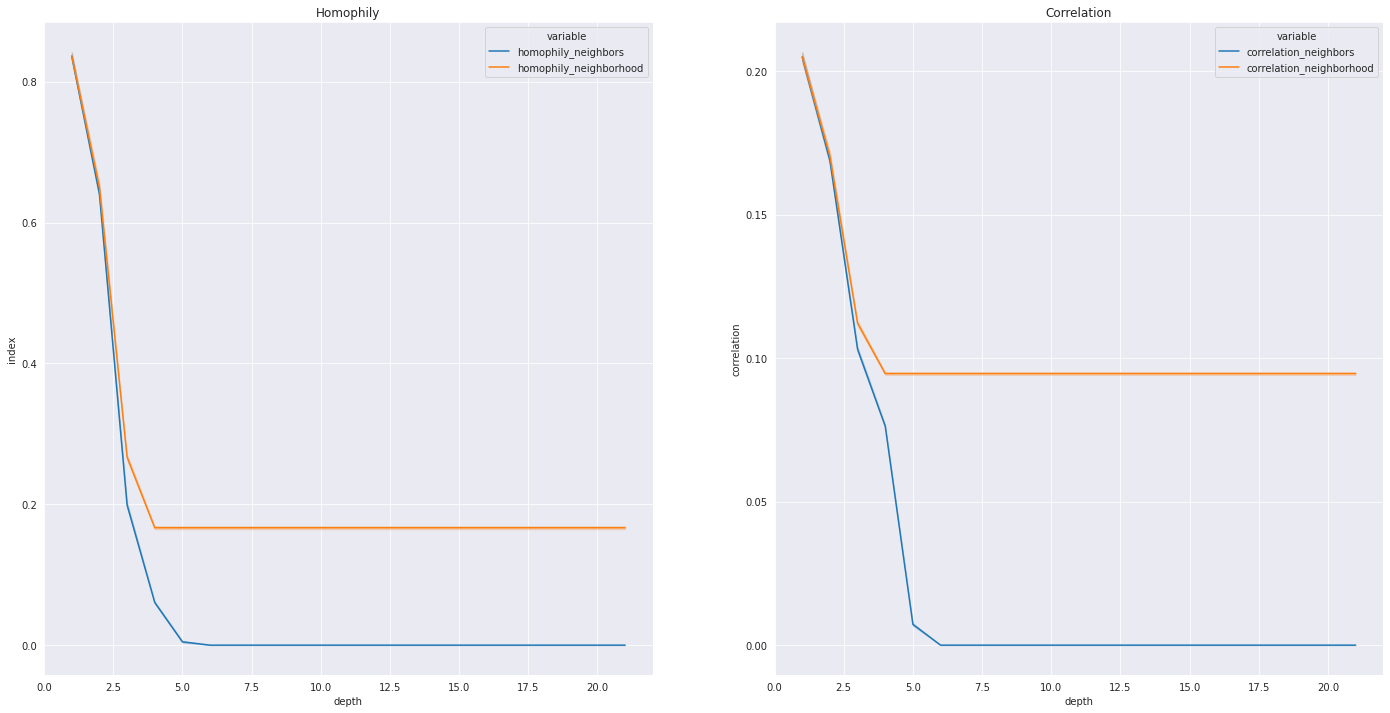

In [ ]:
amazon_summary = graph_summary(amazon)

In [ ]:
amazon_summary.to_csv("./amazon_summary.csv")
files.download('./amazon_summary.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **📰 PubMed**

In [ ]:
pubmed = load_dataset(path, "PubMed")

Processing...
Done!


  0%|          | 0/20 [00:00<?, ?it/s]

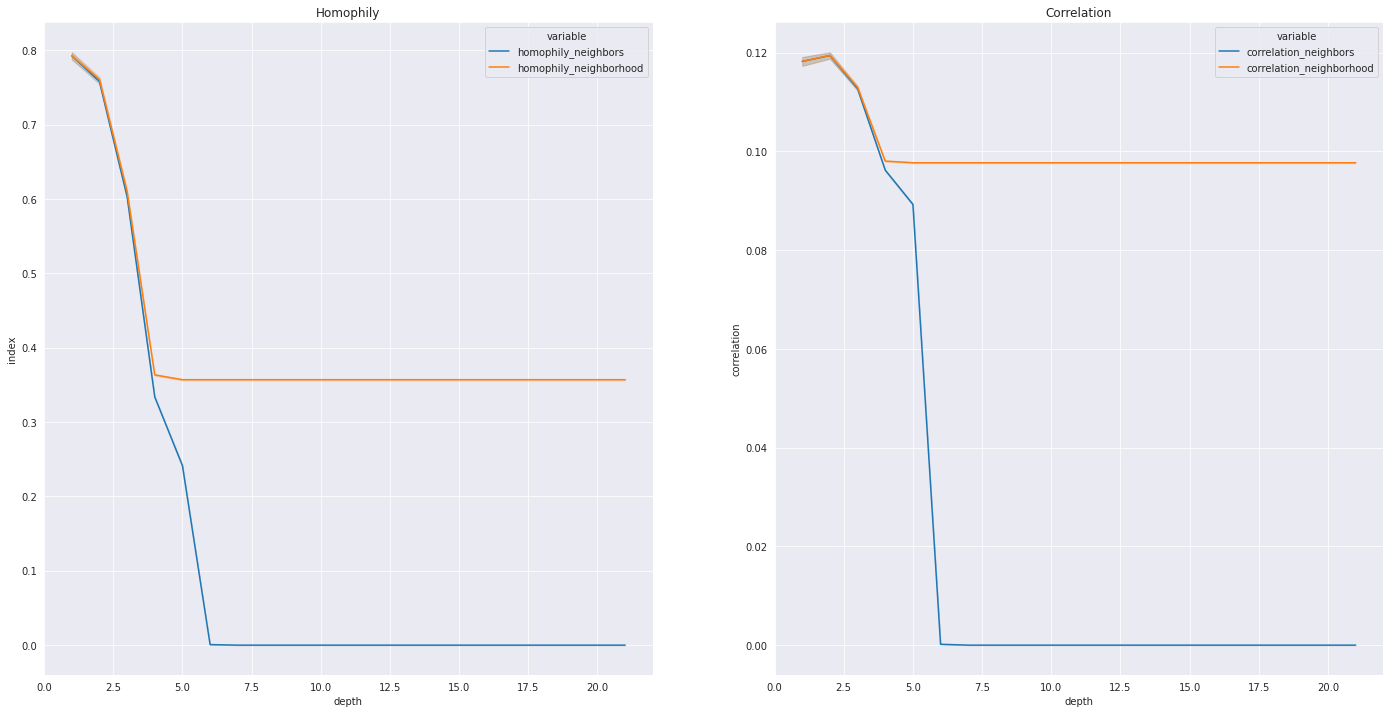

In [ ]:
pubmed_summary = graph_summary(pubmed)

In [ ]:
pubmed_summary.to_csv("./pubmed_summary.csv")
files.download('./pubmed_summary.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **⚛ PPI (protein-protein interaction)**

In [ ]:
ppi = load_dataset(path, "PPI")

Extracting /content/data/ppi.zip
Processing...
Done!


In [ ]:
for i in tqdm(range(len(ppi))):
    summary = graph_summary([ppi[i]])
    if i == 0:
        ppi_summary = summary
    else:
        ppi_summary = pd.concat([ppi_summary, summary], ignore_index=True)

20

### **⚛ QM9 (long-range, graph regression)**

In [ ]:
# amazon dataset
qm9 = load_dataset(path, 'QM9')
qm9

In [ ]:
qm9[5].y.shape

This is a problem! 💥
Every long-range graphs fall under the category of graph classification/regression tasks... In these types of settings we can not measure homophily or graph correlation the way we did with Cora (node classification).